In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['convolutional', 'convolutional-dropout', 'convolutional-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name') #df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name') #df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [13]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [14]:
#out_acc = ['convolutional_out_classifier_auc', 'convolutional-dropout_out_classifier_auc', 'convolutional-poor-bayesian_out_classifier_auc']
out_acc = ['convolutional_out_entropy_auc', 'convolutional-dropout_out_entropy_auc', 'convolutional-poor-bayesian_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

#in_acc = ['convolutional_in_classifier_auc', 'convolutional-dropout_in_classifier_auc', 'convolutional-poor-bayesian_in_classifier_auc']
in_acc = ['convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc', 'convolutional-poor-bayesian_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_898d35be2ee751b9d94e0bc0eaa1393c.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.34  3.8e-4   0.02   1.29   1.32   1.34   1.36   1.39   4000    1.0
theta_free[0]    3.3e-3  3.9e-4   0.02  -0.05-9.6e-3 2.0e-3   0.02   0.05   4000    1.0
theta_free[1]      0.02  4.4e-4   0.03  -0.02 1.2e-3   0.02   0.04   0.08   4000    1.0
sigma_likelihood    0.4  2.6e-4   0.02   0.37   0.39    0.4   0.41   0.44   4000    1.0
sigma_theta        0.18    0.02   0.98 1.8e-3   0.02   0.05   0.11   0.98   4000    1.0
theta[0]         3.3e-3  3.9e-4   0.02  -0.05-9.6e-3 2.0e-3   0.02   0.05   4000    1.0
theta[1]           0.02  4.4e-4   0.03  -0.02 1.2e-3   0.02   0.04   0.08   4000    1.0
theta[2]          -0.03  4.7e-4   0.03  -0.09  -0.04  -0.02-3.0e-3   0.02   4000    1.0
lp__             1

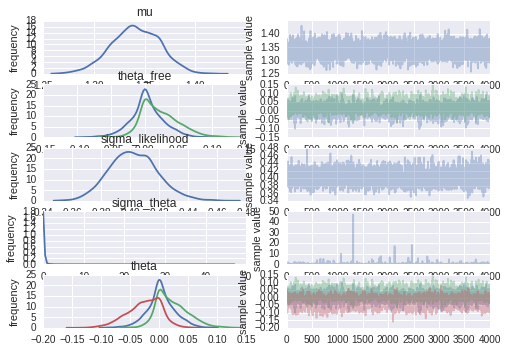

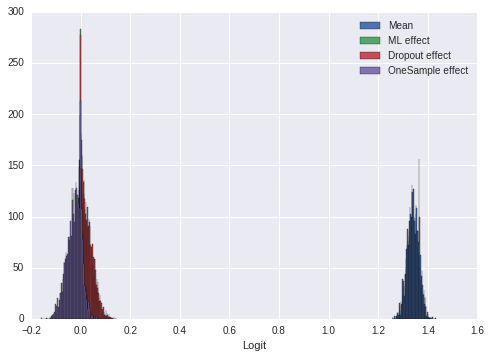

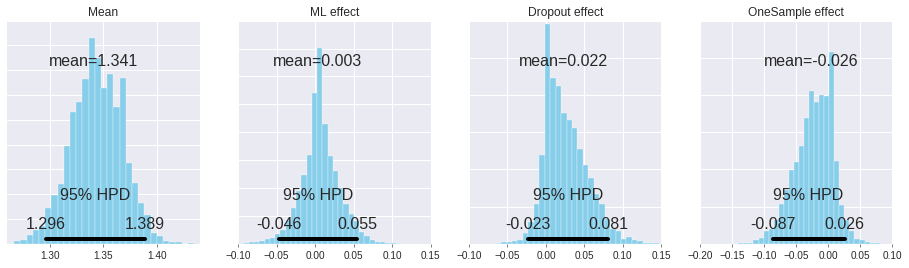

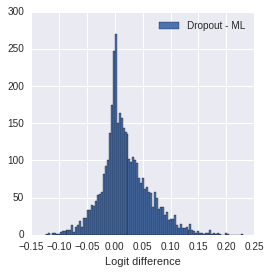

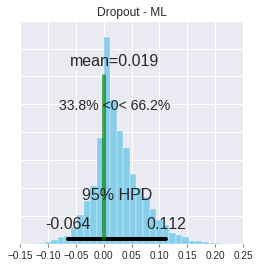

Dropout - ML 95.0 CI: -0.0595502486096 0.1191662249 Pr > 0: 0.6625


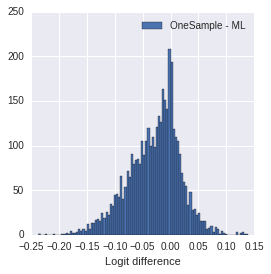

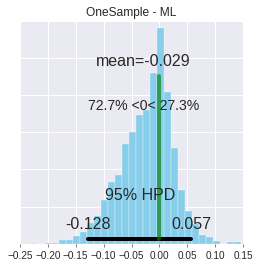

OneSample - ML 95.0 CI: -0.131442977135 0.0543402902222 Pr > 0: 0.273


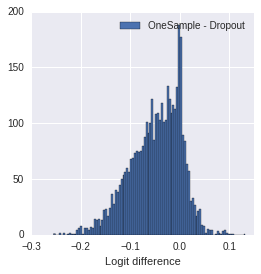

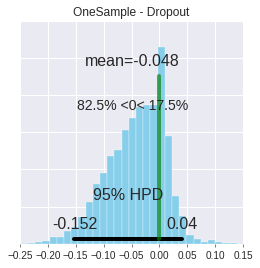

OneSample - Dropout 95.0 CI: -0.160633238625 0.034190506515 Pr > 0: 0.17525


/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_898d35be2ee751b9d94e0bc0eaa1393c.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.04  2.4e-4   0.02   1.01   1.03   1.04   1.05   1.07   4000    1.0
theta_free[0]     -0.02  3.2e-4   0.02  -0.06  -0.03  -0.01-7.9e-4   0.02   4000    1.0
theta_free[1]      0.04  3.6e-4   0.02-3.8e-3   0.02   0.04   0.05   0.08   4000    1.0
sigma_likelihood   0.26  1.7e-4   0.01   0.24   0.26   0.26   0.27   0.29   4000    1.0
sigma_theta        0.22    0.01   0.92 4.6e-3   0.03   0.06   0.13    1.5   4000    1.0
theta[0]          -0.02  3.2e-4   0.02  -0.06  -0.03  -0.01-7.9e-4   0.02   4000    1.0
theta[1]           0.04  3.6e-4   0.02-3.8e-3   0.02   0.04   0.05   0.08   4000    1.0
theta[2]          -0.02  3.2e-4   0.02  -0.06  -0.04  -0.02-7.0e-3   0.02   4000    1.0
lp__             2

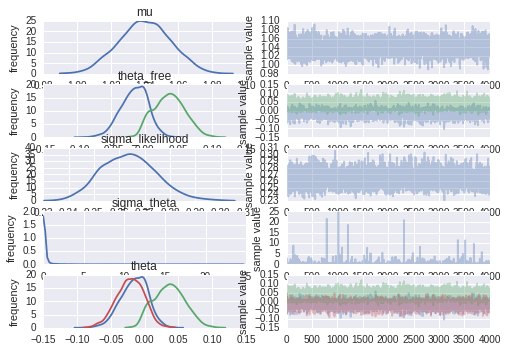

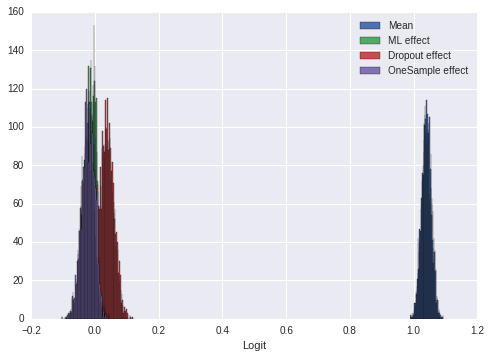

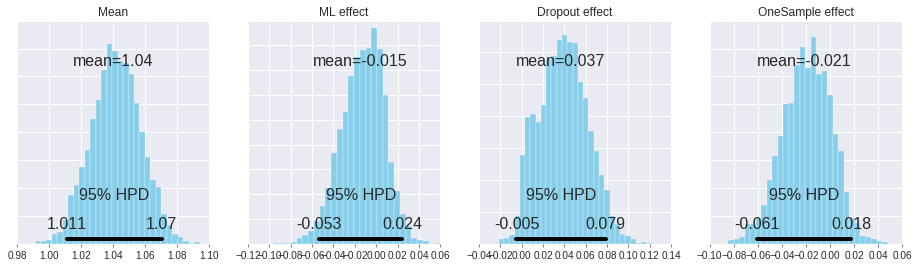

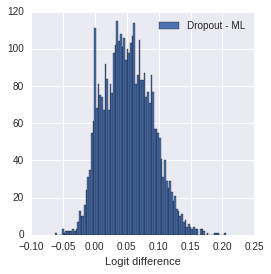

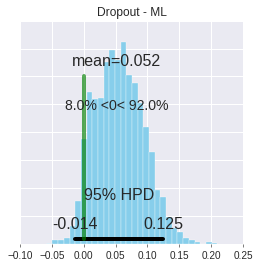

Dropout - ML 95.0 CI: -0.0119589339333 0.127548512646 Pr > 0: 0.92


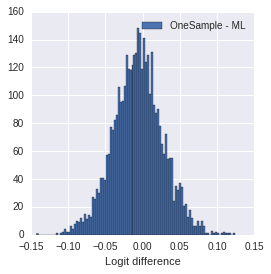

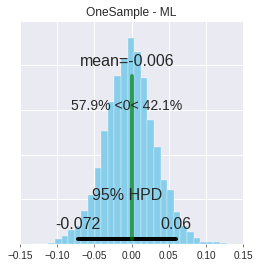

OneSample - ML 95.0 CI: -0.0721595503928 0.059799459348 Pr > 0: 0.42125


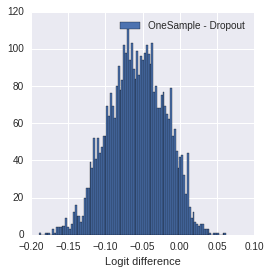

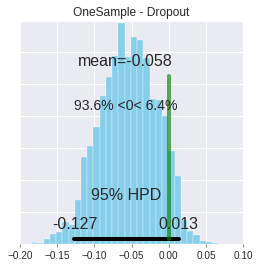

OneSample - Dropout 95.0 CI: -0.133594029334 0.0116169262095 Pr > 0: 0.06375


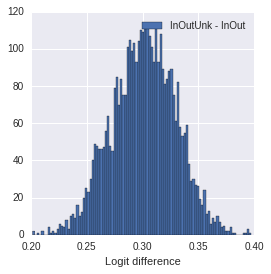

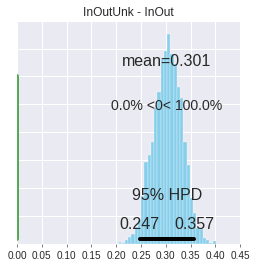

InOutUnk - InOut 95.0 CI: 0.244881805468 0.355232720225 Pr > 0: 1.0


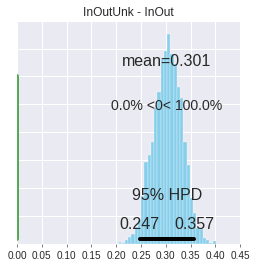

In [15]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Mean", "ML effect", "Dropout effect", "OneSample effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_ddea8e8a9e2bfaae4b2e9caaf410a76a.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              1.34  3.1e-4   0.02    1.3   1.33   1.34   1.35   1.38   4000    1.0
mu_out             1.04  3.1e-4   0.02    1.0   1.03   1.04   1.05   1.08   4000    1.0
theta_free[0]   -6.0e-3  2.8e-4   0.02  -0.04  -0.02-4.8e-3 5.6e-3   0.03   4000    1.0
theta_free[1]      0.03  3.2e-4   0.02-2.7e-3   0.02   0.03   0.05   0.07   4000    1.0
sigma_likelihood   0.34  1.6e-4 9.9e-3   0.32   0.33   0.34   0.35   0.36   4000    1.0
sigma_theta        0.19    0.01    0.8 5.5e-3   0.03   0.05   0.11   1.11   4000    1.0
theta[0]        -6.0e-3  2.8e-4   0.02  -0.04  -0.02-4.8e-3 5.6e-3   0.03   4000    1.0
theta[1]           0.03  3.2e-4   0.02-2.7e-3   0.02   0.03   0.05   0.07   4000    1.0
theta[2]          

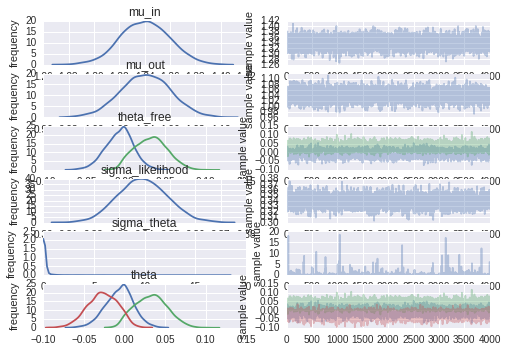

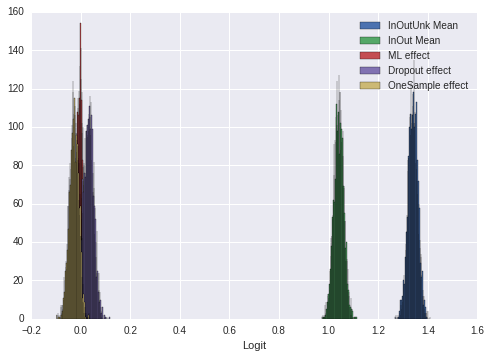

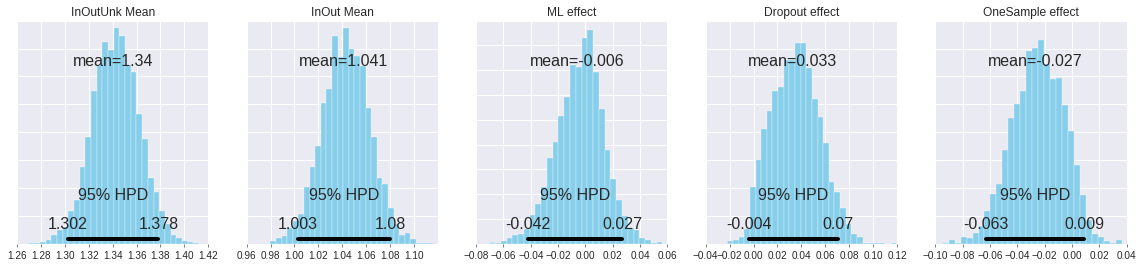

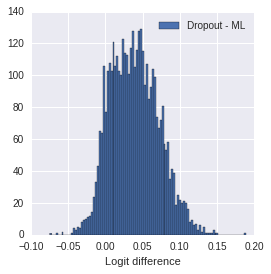

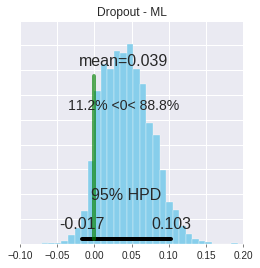

Dropout - ML 95.0 CI: -0.0151560093044 0.105475327218 Pr > 0: 0.8875


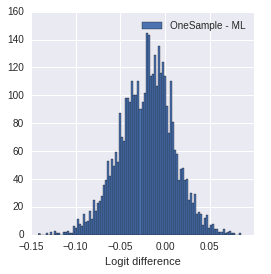

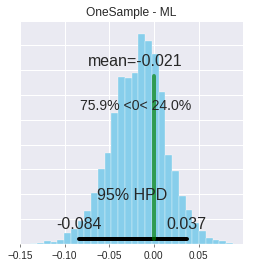

OneSample - ML 95.0 CI: -0.0832047618874 0.0387204942194 Pr > 0: 0.2405


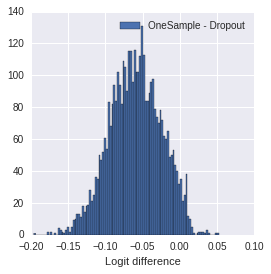

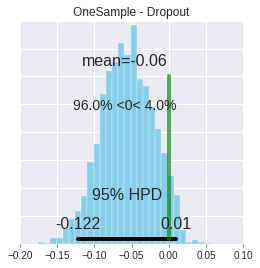

OneSample - Dropout 95.0 CI: -0.129732518469 0.00566692000452 Pr > 0: 0.0405


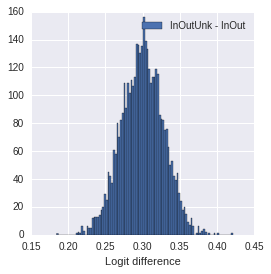

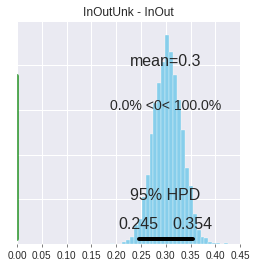

InOutUnk - InOut 95.0 CI: 0.244127079143 0.353420251214 Pr > 0: 1.0


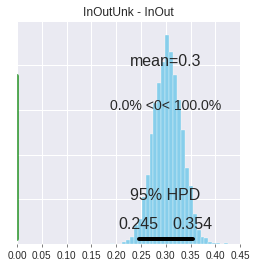

In [17]:
model = pystan.StanModel(model_code=bayesian_anova.two_way_code)

data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model.sampling(data=data, iter=10000, chains=4, thin=5)

bayesian_anova.show_results(fit)

trace = fit.extract()
deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]
in_mean = trace['mu_in']
out_mean = trace['mu_out']

bayesian_anova.plot_traces([in_mean, out_mean, deterministic, dropout, poor_bayesian],
                           ["InOutUnk Mean", "InOut Mean", "ML effect", "Dropout effect", "OneSample effect"])

bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')